
### 05 — AutoEncoder for Collaborative Filtering
Train a denoising autoencoder on the user–movie rating matrix to learn dense representations and produce recommendations.


In [61]:
from pathlib import Path
import sys

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

BASE = Path.cwd().parent
sys.path.append(str(BASE / 'src'))

from autoencoder_model import (
    encode_dense_splits,
    AutoEncoderDataset,
    build_autoencoder,
    run_epoch,
    build_seen_items,
    recommend_topk,
)

PROC = BASE / 'data' / 'processed'
MODELS = BASE / 'models'
MODELS.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [ ]:
train_df = pd.read_csv(PROC / "ratings_train.csv")
valid_df = pd.read_csv(PROC / "ratings_valid.csv")
test_df  = pd.read_csv(PROC / "ratings_test.csv")

for name, df in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(f"{name:>5} -> shape={df.shape}  users={df.userId.nunique()}  items={df.movieId.nunique()}")


train -> shape=(31316, 7)  users=479  items=426
valid -> shape=(3669, 7)  users=479  items=426
 test -> shape=(3669, 7)  users=479  items=426


In [63]:
train_mat, train_mask, valid_mat, valid_mask, test_mat, test_mask, user2idx, item2idx = encode_dense_splits(train_df, valid_df, test_df)
print('Matrix shape:', train_mat.shape, 'train density:', round(float(train_mask.mean()), 4))


Matrix shape: (479, 426) train density: 0.1535


In [64]:
BATCH_SIZE = 64
train_loader = DataLoader(AutoEncoderDataset(train_mat, train_mask), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(AutoEncoderDataset(valid_mat, valid_mask), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(AutoEncoderDataset(test_mat, test_mask), batch_size=BATCH_SIZE, shuffle=False)


In [65]:
model = build_autoencoder(n_items=train_mat.shape[1], hidden_dims=(512, 256, 128), dropout=0.25, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [66]:
EPOCHS = 40
history = {'train_rmse': [], 'valid_rmse': [], 'valid_mae': []}

best_rmse = float('inf')
best_epoch = None
model_path = MODELS / 'autoencoder_best.pth'

for epoch in range(1, EPOCHS + 1):
    train_metrics = run_epoch(model, train_loader, optimizer=optimizer, device=device)
    val_metrics = run_epoch(model, valid_loader, optimizer=None, device=device)

    history['train_rmse'].append(train_metrics.rmse)
    history['valid_rmse'].append(val_metrics.rmse)
    history['valid_mae'].append(val_metrics.mae)

    print(f"Epoch {epoch:02d} | train RMSE={train_metrics.rmse:.4f}  valid RMSE={val_metrics.rmse:.4f}  valid MAE={val_metrics.mae:.4f}")

    if val_metrics.rmse < best_rmse:
        best_rmse = val_metrics.rmse
        best_epoch = epoch
        torch.save({'state_dict': model.state_dict()}, model_path)

print('Best validation RMSE:', best_rmse, 'at epoch', best_epoch)


Epoch 01 | train RMSE=2.7082  valid RMSE=2.0475  valid MAE=1.6663
Epoch 02 | train RMSE=1.8813  valid RMSE=1.7987  valid MAE=1.4380
Epoch 03 | train RMSE=1.7435  valid RMSE=1.7690  valid MAE=1.4253
Epoch 04 | train RMSE=1.7071  valid RMSE=1.7428  valid MAE=1.4050
Epoch 05 | train RMSE=1.6844  valid RMSE=1.7284  valid MAE=1.3957
Epoch 06 | train RMSE=1.6760  valid RMSE=1.7276  valid MAE=1.3941
Epoch 07 | train RMSE=1.6719  valid RMSE=1.7313  valid MAE=1.3966
Epoch 08 | train RMSE=1.6703  valid RMSE=1.7228  valid MAE=1.3895
Epoch 09 | train RMSE=1.6664  valid RMSE=1.7226  valid MAE=1.3898
Epoch 10 | train RMSE=1.6505  valid RMSE=1.7110  valid MAE=1.3804
Epoch 11 | train RMSE=1.6425  valid RMSE=1.7091  valid MAE=1.3794
Epoch 12 | train RMSE=1.6427  valid RMSE=1.7074  valid MAE=1.3781
Epoch 13 | train RMSE=1.6442  valid RMSE=1.7166  valid MAE=1.3854
Epoch 14 | train RMSE=1.6454  valid RMSE=1.7182  valid MAE=1.3858
Epoch 15 | train RMSE=1.6412  valid RMSE=1.7087  valid MAE=1.3791
Epoch 16 |

In [67]:
EPOCHS = 80
PATIENCE = 8
best_val_rmse = float('inf')
best_epoch = 0
wait = 0

history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
checkpoint_path = MODELS / 'autoencoder_best.pth'

for epoch in range(1, EPOCHS + 1):
    train_metrics = run_epoch(model, train_loader, optimizer=optimizer, device=device)
    val_metrics = run_epoch(model, valid_loader, optimizer=None, device=device)

    history['train_loss'].append(train_metrics.loss)
    history['val_loss'].append(val_metrics.loss)
    history['val_rmse'].append(val_metrics.rmse)
    history['val_mae'].append(val_metrics.mae)

    print(
        f"Epoch {epoch:02d} | train_loss={train_metrics.loss:.4f} | "
        f"val_loss={val_metrics.loss:.4f} | val_RMSE={val_metrics.rmse:.4f} | val_MAE={val_metrics.mae:.4f}"
    )

    if val_metrics.rmse + 1e-4 < best_val_rmse:
        best_val_rmse = val_metrics.rmse
        best_epoch = epoch
        wait = 0
        torch.save(
            {
                'state_dict': model.state_dict(),
                'user2idx': user2idx.to_dict(),
                'item2idx': item2idx.to_dict(),
                'history': history,
                'best_val_rmse': best_val_rmse,
            },
            checkpoint_path,
        )
    else:
        wait += 1
        if wait >= PATIENCE:
            print('Early stopping triggered.')
            break

print(f"Best validation RMSE {best_val_rmse:.4f} at epoch {best_epoch}")


Epoch 01 | train_loss=2.6803 | val_loss=2.9810 | val_RMSE=1.7103 | val_MAE=1.3802
Epoch 02 | train_loss=2.7012 | val_loss=2.9810 | val_RMSE=1.7103 | val_MAE=1.3802
Epoch 03 | train_loss=2.7100 | val_loss=2.9810 | val_RMSE=1.7103 | val_MAE=1.3802
Epoch 04 | train_loss=2.7299 | val_loss=2.9810 | val_RMSE=1.7103 | val_MAE=1.3802
Epoch 05 | train_loss=2.7063 | val_loss=2.9811 | val_RMSE=1.7103 | val_MAE=1.3802
Epoch 06 | train_loss=2.6937 | val_loss=2.9869 | val_RMSE=1.7109 | val_MAE=1.3807
Epoch 07 | train_loss=2.7341 | val_loss=2.9810 | val_RMSE=1.7103 | val_MAE=1.3802
Epoch 08 | train_loss=2.6980 | val_loss=2.9757 | val_RMSE=1.7095 | val_MAE=1.3791
Epoch 09 | train_loss=2.7197 | val_loss=3.0106 | val_RMSE=1.7175 | val_MAE=1.3856
Epoch 10 | train_loss=2.6862 | val_loss=3.0106 | val_RMSE=1.7175 | val_MAE=1.3856
Epoch 11 | train_loss=2.7025 | val_loss=3.0266 | val_RMSE=1.7219 | val_MAE=1.3890
Epoch 12 | train_loss=2.7103 | val_loss=3.0266 | val_RMSE=1.7219 | val_MAE=1.3890
Epoch 13 | train

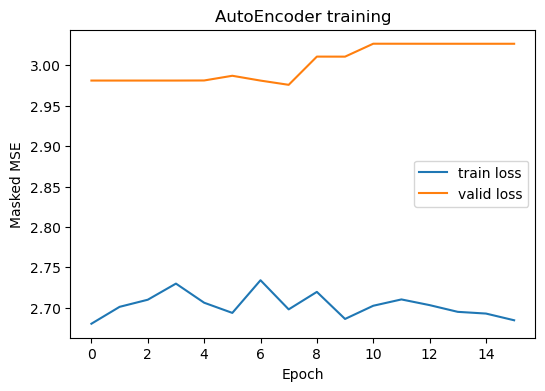

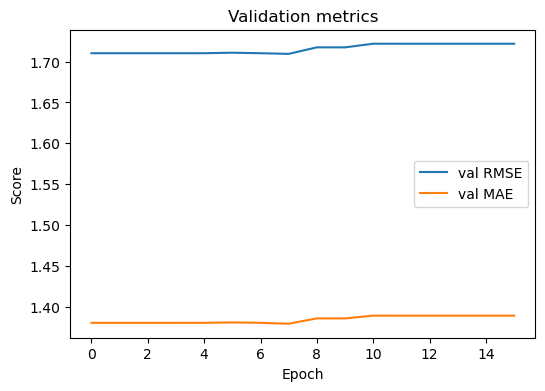

In [68]:
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Masked MSE')
plt.legend()
plt.title('AutoEncoder training')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['val_rmse'], label='val RMSE')
plt.plot(history['val_mae'], label='val MAE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation metrics')
plt.show()


In [69]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

test_metrics = run_epoch(model, test_loader, optimizer=None, device=device)
print(f"Test RMSE: {test_metrics.rmse:.4f} | Test MAE: {test_metrics.mae:.4f}")


Test RMSE: 1.7368 | Test MAE: 1.3796


In [70]:
train_seen = build_seen_items(train_df)
movies_meta = pd.read_csv(PROC / 'movies_enriched.csv', usecols=['movieId', 'title', 'genres'])

sample_user = int(train_df['userId'].sample(1, random_state=42).iloc[0])
recs = recommend_topk(
    model,
    sample_user,
    train_matrix=train_mat,
    user2idx=user2idx,
    item2idx=item2idx,
    train_seen=train_seen,
    k=10,
    device=device,
).merge(movies_meta, on='movieId', how='left')

print('Sample user:', sample_user)
display(recs)


Sample user: 591


,movieId,score,title,genres
0,595,5.0,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
1,4995,5.0,"Beautiful Mind, A (2001)",Drama|Romance
2,4896,5.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
3,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
4,5445,5.0,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller
5,2078,5.0,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical
6,2700,5.0,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical
7,5502,5.0,Signs (2002),Horror|Sci-Fi|Thriller
8,4973,5.0,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
9,4308,5.0,Moulin Rouge (2001),Drama|Musical|Romance
